***Participantes (RM - NOME):***<br>
Vitor Luiz Carvalhal - 337129<br>
Ricardo Fabbro Antonelli - 339505<br>
Bartira Lira Lafiandre - 340177<br>
Tiago Batista Pessoa - 339575<br>


## 0. Bibliotecas e afins

In [1]:
#Alocando memoria extra no colab
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 27.3 gigabytes of available RAM

You are using a high-RAM runtime!


In [2]:
#Bibliotecas
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D,AveragePooling2D
from keras.utils.np_utils import to_categorical
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import preprocessing
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import losses

import numpy as np
import pandas as pd
import os
import glob
import shutil
import cv2


!pip install ipython-autotime
%load_ext autotime

time: 196 µs (started: 2021-07-18 15:31:50 +00:00)


In [3]:
# monta google drive
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive
time: 49min 39s (started: 2021-07-18 15:31:50 +00:00)


## 1.Analisando os dados

In [4]:
#ler arquivo com a avaliação das imagens
url = '/content/drive/MyDrive/Dataset/CoronaHack/Chest_xray_Corona_Metadata.csv'
nome_arquivos = pd.read_csv(url, engine='python', delimiter=",")
nome_arquivos.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


time: 1.38 s (started: 2021-07-18 16:21:30 +00:00)


In [7]:
#verificando quantas imagens temos de cada classe inicial
nome_arquivos.Label.value_counts()

Pnemonia    4334
Normal      1576
Name: Label, dtype: int64

time: 6.76 ms (started: 2021-07-17 00:11:15 +00:00)


In [8]:
#verificando quantas imagens temos de cada dataset
nome_arquivos.Dataset_type.value_counts()

TRAIN    5286
TEST      624
Name: Dataset_type, dtype: int64

time: 6.48 ms (started: 2021-07-17 00:11:16 +00:00)


In [9]:
#verificando quantas imagens temos de cada dataset
nome_arquivos.groupby(["Dataset_type","Label"], dropna=False)["X_ray_image_name"].count()

Dataset_type  Label   
TEST          Normal       234
              Pnemonia     390
TRAIN         Normal      1342
              Pnemonia    3944
Name: X_ray_image_name, dtype: int64

time: 9.17 ms (started: 2021-07-17 00:11:17 +00:00)


In [10]:
# agrupando para ver quais seriam as demais categorias
nome_arquivos.groupby(["Dataset_type","Label","Label_2_Virus_category","Label_1_Virus_category"], dropna=False)["X_ray_image_name"].count()

Dataset_type  Label     Label_2_Virus_category  Label_1_Virus_category
TEST          Normal    NaN                     NaN                        234
              Pnemonia  NaN                     Virus                      148
                                                bacteria                   242
TRAIN         Normal    NaN                     NaN                       1342
              Pnemonia  ARDS                    Stress-Smoking               2
                        COVID-19                Virus                       58
                        SARS                    Virus                        4
                        Streptococcus           bacteria                     5
                        NaN                     Virus                     1345
                                                bacteria                  2530
Name: X_ray_image_name, dtype: int64

time: 12.9 ms (started: 2021-07-17 00:11:19 +00:00)


## 2. Vamos analisar e tratar as imagens
**Esse bloco demora 40min**

In [ ]:
# checando quantas imagens temos no diretorio de treino
path = '/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train'
images_train = [f for f in os.listdir(path)]
len(images_train)

In [ ]:
# checando quantas imagens temos no diretorio de teste
path = '/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test'
images_test = [f for f in os.listdir(path)]
len(images_test)

> * temos mais imagens do que avalições na planilha para o conjunto de treino. Vamos ter que coletar apenas as imagens que possui avaliação se é pneumonia ou não

* **Antes, vamos dar uma olhada no tamanho medio das imagens**


In [ ]:
#descobrindo o tamanho médio das imagens.(L x A)
# ESSE BLOCO DEMORA BASTANTE, LEVA EM MEDIA 1h. o TAMANHO MEDIO DAS IMAGENS EH: 970 X 1329
imgsize_real=[]
path="/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/"
for f in os.listdir(path):
  imgsize_real.append((cv2.imread(path+f).shape[0],
                       cv2.imread(path+f).shape[1]))
  
a = np.array(imgsize_real)
np.average(a, axis=0)

In [ ]:
# vendo a distribuição dos tamanhos
plt.hist(a)

In [ ]:
print("menor L e A",min(imgsize_real))
print("maoir L e A",max(imgsize_real))

> Pegando uma imagem aleatoria para olhar a qualidade e ver como melhorar essa imagem após o redimensionamento

In [ ]:
cor_imagem=cv2.imread("/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train/person1944_bacteria_4869.jpeg")

In [ ]:
cor_imagem.shape

In [ ]:
cores = {"r": 0, "g": 1, "b": 2}
def histograma_bgr(imagem):
    for cor in cores:
        histograma = cv2.calcHist([imagem],[cores[cor]],None,[256],[0,256])
        plt.plot(histograma,color = cor)
        plt.xlim([0,256])
    plt.show()


histograma_bgr(cor_imagem)

> Essa imagem mostra que tem 3 canais de cores. Vamos transformar para escala de cinza

In [ ]:
imagem_gray = cv2.cvtColor(cor_imagem, cv2.COLOR_BGR2GRAY)
imagem_gray.shape

In [ ]:
plt.figure(figsize=(20,10))
plt.title("imagem tamanho original transformada para cinza")
plt.imshow(imagem_gray, cmap = "gray")

In [ ]:
imagem_gray2 = cv2.cvtColor(cv2.resize(cor_imagem,(200,200)),cv2.COLOR_BGR2GRAY)

plt.figure(figsize=(20,10))
plt.title("imagem em escala de cinza e redimencionada para 500 x 500")
plt.imshow(imagem_gray2, cmap = "gray")

In [ ]:
#imagem suavizada
imagem_suavizada = cv2.GaussianBlur(imagem_gray2, (5, 5), 0)

#plt.axis('off')
plt.figure(figsize=(20,10))
plt.imshow(imagem_suavizada, cmap='gray')
plt.title("Suavização Gaussiana")

> Não acho que a suavização tenha melhorado a qualidade da imagem

## 3. Movendo e transformando as imagems.
Preparando para mover as imagens.Essa etapa faz uma copia da imagem do diretorio original e separa em pastas. - **ESSA ETAPA DEMORA 40MIN**

* **Ok, agora vamos tratar as imagens em diretorios de acordo as suas classes. Faremos primeiro para as imagens de treino e depois para as de teste.**
* **Onde temos pneumonia, vamos segregar entre COVID e pneumonia em geral. Se for normal, atribuiremos "Normal"**

In [ ]:
# Criando lista de tuplas para treino e teste
listItensTreino=[]
listItensTest=[]
for i,j in nome_arquivos.iterrows():
  if (j["Dataset_type"] == "TRAIN" and j["Label"] == "Normal"):
      listItensTreino.append([j["X_ray_image_name"],j["Label"]])
  elif (j["Dataset_type"]== "TRAIN" and j["Label_2_Virus_category"]=="COVID-19"):
        listItensTreino.append([j["X_ray_image_name"],"COVID-19"])
  elif j["Dataset_type"]== "TRAIN":
        listItensTreino.append([j["X_ray_image_name"],"Pneumonia"])
  elif (j["Dataset_type"] == "TEST" and j["Label"] == "Normal"):
        listItensTest.append([j["X_ray_image_name"],j["Label"]])
  elif (j["Dataset_type"]== "TEST" and j["Label_2_Virus_category"]=="COVID-19"):
        listItensTest.append([j["X_ray_image_name"],"COVID-19"])
  elif j["Dataset_type"]== "TEST":
        listItensTest.append([j["X_ray_image_name"],"Pneumonia"])

print(len(listItensTreino))
print(len(listItensTest))

5286
624
time: 609 ms (started: 2021-07-16 15:31:24 +00:00)


In [ ]:
#vendo como ficou a sumarização para criar os diretorios
#treino
from collections import Counter
Counter(elem[1] for elem in listItensTreino)

Counter({'COVID-19': 58, 'Normal': 1342, 'Pneumonia': 3886})

time: 7.98 ms (started: 2021-07-16 15:31:27 +00:00)


In [ ]:
#criando os diretorios para treino
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/COVID-19")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/Normal")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/Pneumonia")


time: 18.3 ms (started: 2021-07-16 15:09:37 +00:00)


In [ ]:
#vendo como ficou a sumarização para criar os diretorios
#teste
from collections import Counter
Counter(elem[1] for elem in listItensTest)

Counter({'Normal': 234, 'Pneumonia': 390})

time: 9.2 ms (started: 2021-07-16 15:31:30 +00:00)


In [ ]:
#criando os diretorios para test
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/Normal")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/Pneumonia")
os.mkdir("/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/COVID-19")

time: 16 ms (started: 2021-07-16 15:09:43 +00:00)


### 3.1 Copiando as imagens para seus diretorios e redimensionando para 500 pixels e transformando em escala de cinza.

---



In [ ]:
#TRAIN
#copiando as imagens para seus respectivos diretorios
# ESSA ETAPA SO DEVE SER FEITA UMA VEZ PARA ORGANIZAR AS IMAGENS
train_dir= "/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train"
train_dir_normal = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/Normal"
train_dir_COVID_19 = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/COVID-19"
train_dir_pneumonia = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train/Pneumonia"

for i in listItensTreino:
  if i[1]=="Normal":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(train_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(train_dir_normal,i[0]), image_norm)
  elif i[1]=="COVID-19":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(train_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(train_dir_COVID_19,i[0]), image_norm)
  elif i[1]=="Pneumonia":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(train_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(train_dir_pneumonia,i[0]), image_norm)



time: 2min 57s (started: 2021-07-16 15:12:14 +00:00)


In [ ]:
#TEST
#copiando as imagens para seus respectivos diretorios
# ESSA ETAPA SO DEVE SER FEITA UMA VEZ PARA ORGANIZAR AS IMAGENS
test_dir= "/content/drive/MyDrive/Dataset/CoronaHack/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test"
test_dir_normal = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/Normal"
test_dir_pneumonia = "/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test/Pneumonia"

for i in listItensTest:
  if i[1]=="Normal":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(test_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(test_dir_normal,i[0]), image_norm)
  elif i[1]=="Pneumonia":
    image_norm= cv2.cvtColor(cv2.resize(cv2.imread(os.path.join(test_dir,i[0])),(200,200)), cv2.COLOR_BGR2GRAY)
    cv2.imwrite(os.path.join(test_dir_pneumonia,i[0]), image_norm)


time: 3min 15s (started: 2021-07-16 15:15:20 +00:00)


## 4. criando os arquivos de treino e teste

In [54]:
#utilizaremos o orquestrador de imagem "DataGenerator"
#load das imagens com aumentation . Separando em treino e 20% validação
train_datagen = preprocessing.image.ImageDataGenerator(validation_split=0.20)

time: 2.1 ms (started: 2021-07-18 18:55:54 +00:00)


> Usaremos um batch_size de 500 pois temos muitas imagens e uma imagem de 500 x 500 pois, de acordo com o histograma apresentado anteriormente, esse é um valor seguro.

In [55]:
#Criando subset de treino
train_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train',
    batch_size=500,
    color_mode = 'grayscale',
    #class_mode="categorical",
    subset='training',
    target_size=(200, 200))

Found 4230 images belonging to 3 classes.
time: 221 ms (started: 2021-07-18 18:55:55 +00:00)


In [56]:
#criando subset de validação
valid_generator = train_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/train',
    batch_size=500,
    color_mode = 'grayscale',
    #class_mode="categorical",
    subset='validation',
    target_size=(200, 200))

Found 1056 images belonging to 3 classes.
time: 108 ms (started: 2021-07-18 18:55:56 +00:00)


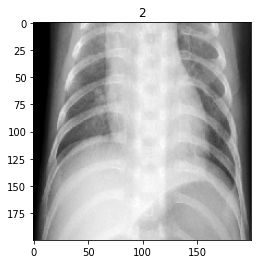

time: 2.73 s (started: 2021-07-18 18:55:57 +00:00)


In [57]:
#Visualizando 
x,y = train_generator.next()
for i in range(0,1):
    image = x[i]   
    plt.title(y[i].argmax(axis=-1))
    plt.imshow(image[:,:,0],cmap='gray')
    plt.show()
    



In [9]:
num_classes = len(train_generator.class_indices)
print(num_classes)

3
time: 1.69 ms (started: 2021-07-18 16:26:12 +00:00)


In [58]:
#pegando o tamanho da imagem para usar na modelagem
imgsize = x.shape
print(imgsize[1])
print(imgsize[2])
print(imgsize[3])

200
200
1
time: 2.32 ms (started: 2021-07-18 18:56:07 +00:00)


## 5. Modelando a rede

### Modeling: LeNet-5 implmentation

![lenet.png](https://raw.githubusercontent.com/MostafaGazar/mobile-ml/master/files/lenet.png)
> LeNet-5 Architecture. Credit: [LeCun et al., 1998](http://yann.lecun.com/exdb/publis/psgz/lecun-98.ps.gz)



**The following part is heavily inspired by** https://github.com/udacity/CarND-LeNet-Lab/blob/master/LeNet-Lab-Solution.ipynb

#### Input
    32x32x1 pixels image
    
#### Architecture
* **Convolutional #1** outputs 28x28x6
    * **Activation** any activation function, we will `relu`

* **Pooling #1** The output shape should be 14x14x6.

* **Convolutional #2** outputs 10x10x16.
    * **Activation** any activation function, we will `relu`

* **Pooling #2** outputs 5x5x16.
    * **Flatten** Flatten the output shape of the final pooling layer

* **Fully Connected #1** outputs 120
    * **Activation** any activation function, we will `relu`

* **Fully Connected #2** outputs 84
    * **Activation** any activation function, we will `relu`

* **Fully Connected (Logits) #3** outpute 10

In [59]:
#Definindo quantidade de passos pela divisao da quantidade de imagens pelo tamanho do bach
STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size

print("Quantidade de passos para treino = ",STEP_SIZE_TRAIN)
print("Quantidade de passos para validacao = ",STEP_SIZE_VALID)

Quantidade de passos para treino =  8
Quantidade de passos para validacao =  2
time: 2.19 ms (started: 2021-07-18 18:56:10 +00:00)


In [60]:
model = Sequential()

model.add(Conv2D(32, (7, 7), input_shape=(imgsize[1],imgsize[2],imgsize[3]), activation='relu')) 

model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(AveragePooling2D(pool_size=(2, 2)))

model.add(Flatten())

print( model.output_shape)
model.add(Dense(512, activation='relu'))
print( model.output_shape)
model.add(Dense(128, activation='relu'))
print( model.output_shape)
model.add(Dense(64, activation='relu'))
print( model.output_shape)

model.add(Dense(num_classes, activation = 'softmax'))
print( model.output_shape)

(None, 282752)
(None, 512)
(None, 128)
(None, 64)
(None, 3)
time: 743 ms (started: 2021-07-18 18:56:11 +00:00)


In [61]:
# compilando o modelo
#model.compile(loss=losses.categorical_crossentropy, optimizer=optimizers.Adam(), metrics=['accuracy'])
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

time: 8.81 ms (started: 2021-07-18 18:56:13 +00:00)


In [62]:
# adicionando o model checkpoint para guardar o melhor resultado do modelo
mcp_save = ModelCheckpoint('/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack.hdf5', monitor='val_accuracy', mode= 'auto', save_best_only=True, verbose =1)
# save_weights_only=True,

time: 1.61 ms (started: 2021-07-18 18:56:14 +00:00)


In [63]:
#vendo o resultado do modelo
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 194, 194, 32)      1600      
_________________________________________________________________
average_pooling2d_4 (Average (None, 97, 97, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 95, 95, 128)       36992     
_________________________________________________________________
average_pooling2d_5 (Average (None, 47, 47, 128)       0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 282752)            0         
_________________________________________________________________
dense_8 (Dense)              (None, 512)               144769536 
_________________________________________________________________
dense_9 (Dense)              (None, 128)              

> **O TREINO DO MODELO COM 50 EPOCAS LEVOU 3HS**

In [64]:
# treinando o modelo
hist=model.fit_generator(train_generator, 
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=20, 
                    callbacks=[mcp_save])



/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1940: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
8/8 [==============================] - 183s 22s/step - loss: 353.1307 - accuracy: 0.5525 - val_loss: 3.1596 - val_accuracy: 0.7350

Epoch 00001: val_accuracy improved from -inf to 0.73500, saving model to /content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack.hdf5
Epoch 2/20
8/8 [==============================] - 164s 20s/step - loss: 8.4161 - accuracy: 0.6252 - val_loss: 0.5287 - val_accuracy: 0.8240

Epoch 00002: val_accuracy improved from 0.73500 to 0.82400, saving model to /content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack.hdf5
Epoch 3/20
8/8 [==============================] - 182s 20s/step - loss: 0.5145 - accuracy: 0.8426 - val_loss: 0.4193 - val_accuracy: 0.8260

Epoch 00003: val_accuracy improved from 0.82400 to 0.82600, saving model to /content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack.hdf5
Epoch 4/20
8/8 [==============================] - 168s 20s/step - loss: 0.3219 - accuracy: 0.8936 - val_loss: 4.2704 - val_accuracy: 0.2620

Ep

## 6. Avaliando o modelo e Testando conjunto de teste

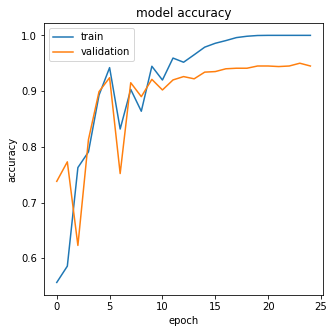

time: 317 ms (started: 2021-07-18 18:14:05 +00:00)


In [17]:
plt.figure(figsize=(5,5)) 
plt.figure(1)
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

**Avaliação no conjunto de treinamento e validação:**<br>
Tentativa com 10 epocas = Acuracia de validação de 90% com loss de 0.24. <br>
Tentativa com 50 epocas = Acuracia de validação de 95% com loss de 0.24.<br>
Tentatica com 25 epocas = Acuracia de validação de 95% com loss de 0.29<br>

In [18]:
#gerando dados de teste
test_datagen = preprocessing.image.ImageDataGenerator()
test_generator = test_datagen.flow_from_directory(
    '/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/test',
    batch_size=1,
    color_mode = 'grayscale',
    #class_mode="categorical",
    shuffle = False,
    target_size=(200, 200))

Found 624 images belonging to 3 classes.
time: 3.54 s (started: 2021-07-18 18:14:06 +00:00)


In [19]:
#avaliação do modelo
scores = model.evaluate_generator(test_generator)   

print("%s%.2f  "% ("Loss     : ", scores[0]))
print("%s%.2f%s"% ("Accuracy : ", scores[1]*100, "%"))


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:1973: UserWarning: `Model.evaluate_generator` is deprecated and will be removed in a future version. Please use `Model.evaluate`, which supports generators.
  warnings.warn('`Model.evaluate_generator` is deprecated and '


Loss     : 2.77  
Accuracy : 71.96%
time: 4min 53s (started: 2021-07-18 18:14:09 +00:00)


**Avaliação no conjunto de teste:**<br>
10 Epocas > Acuracia: 74,52% e loss:0.73<br>
50 Epocas > Acuracia: 74,20% e loss:2.01<br>
25 Epocas > Acuracia: 71,96% e loss:2.77<br>

> realiza a predicao no conjunto de teste e usando argmax para selecionar a melhor predição

In [30]:
#realiza a predição no conjunto de teste
predictions = model.predict_generator(test_generator, steps=len(test_generator), verbose=1)
y_pred = predictions.argmax(axis=-1)
y_true=test_generator.classes

  1/624 [..............................] - ETA: 1:12

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/training.py:2001: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  warnings.warn('`Model.predict_generator` is deprecated and '


624/624 [==============================] - 48s 77ms/step
time: 48.2 s (started: 2021-07-18 18:47:41 +00:00)


In [31]:
#classes encontradas no conjunto de teste
test_generator.class_indices

{'COVID-19': 0, 'Normal': 1, 'Pneumonia': 2}

time: 4.36 ms (started: 2021-07-18 18:48:29 +00:00)


In [32]:
#jogando os labels do conjunto de teste numa lista
labels = []
for l, v in test_generator.class_indices.items():
    labels.append((v,l))
labels   

[(0, 'COVID-19'), (1, 'Normal'), (2, 'Pneumonia')]

time: 6.35 ms (started: 2021-07-18 18:48:29 +00:00)


In [33]:
#jogando as predicoes numa lista usando o argmax para selecionar a melhor predicao de cada vetor
y_pred_list = []
for p in range(predictions.shape[0]):
    y_pred_list.append(predictions[p].argmax(axis=-1))

time: 4.31 ms (started: 2021-07-18 18:48:29 +00:00)


In [34]:
def join(l1, l2):
  return [list(x) for x in zip(l1, l2)]

print(join(y_true, y_pred))

[[1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 0], [1, 2], [1, 2], [1, 1], [1, 0], [1, 2], [1, 0], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 1], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 1], [1, 1], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 1], [1, 2], [1, 2], [1, 1], [1, 1], [1, 2], [1, 2], [1, 1], [1, 1], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 1], [1, 1], [1, 1], [1, 1], [1, 2], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 1], [1, 1], [1, 2], [1, 2], [1, 2], [1, 1], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2], [1, 2],

In [35]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

print(classification_report(y_true, y_pred))
pred_class= model.predict_classes(test_generator)
print('Accuracy Score:\n', accuracy_score(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.00      0.00      0.00         0
           1       0.94      0.27      0.42       234
           2       0.70      0.99      0.82       390

    accuracy                           0.72       624
   macro avg       0.55      0.42      0.41       624
weighted avg       0.79      0.72      0.67       624



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/engine/sequential.py:455: UserWarning: `model.predict_classes()` is deprecated and will be removed after 2021-01-01. Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).
  warnings.warn('`model.predict_classes()` is deprecated and '


Accuracy Score:
 0.719551282051282
time: 45.4 s (started: 2021-07-18 18:48:30 +00:00)


/usr/local/lib/python3.7/dist-packages/mlxtend/plotting/plot_confusion_matrix.py:59: RuntimeWarning: invalid value encountered in true_divide
  normed_conf_mat = conf_mat.astype('float') / total_samples


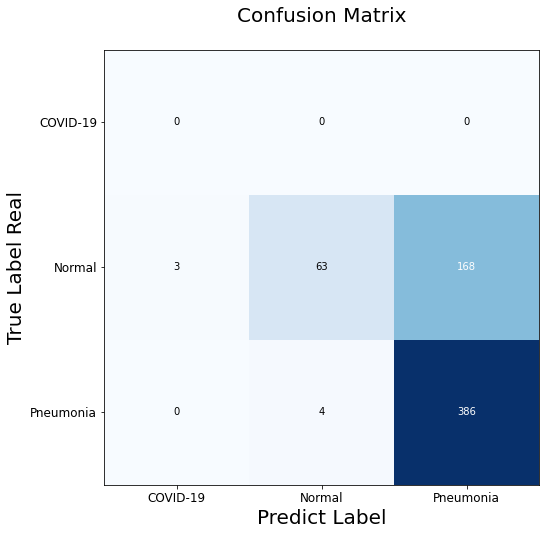

time: 168 ms (started: 2021-07-18 18:49:15 +00:00)


In [36]:
from mlxtend.plotting import plot_confusion_matrix
#confusion_matrix(y_true, y_pred)
#plot_confusion_matrix(model, y_true, y_pred, normalize='true')
classes=test_generator.class_indices



CM = confusion_matrix(y_true, y_pred)

fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(10,8), hide_ticks=True,cmap=plt.cm.Blues)
plt.xticks(range(len(classes)), classes, fontsize=12)
plt.yticks(range(len(classes)), classes, fontsize=12)
plt.title("Confusion Matrix", fontsize=20)
plt.ylabel('True Label Real',fontsize=20)
plt.xlabel('Predict Label',fontsize=20)
plt.show()

1  igual 2


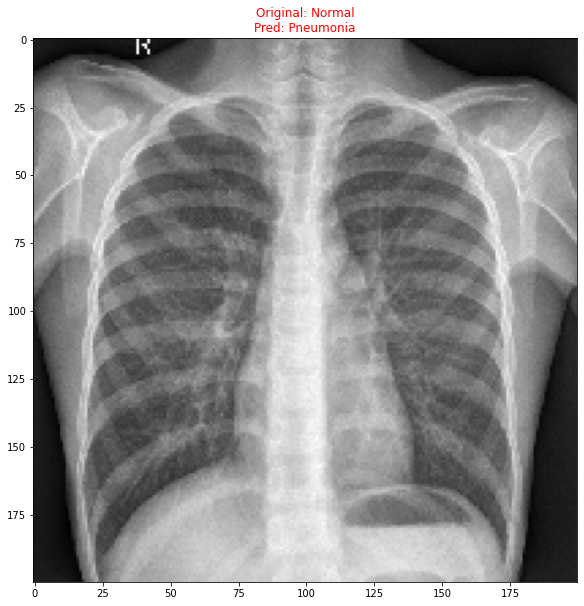

time: 499 ms (started: 2021-07-18 18:55:29 +00:00)


In [53]:
#genrado a avaliação na imagem usando o generator.next()
x,y = test_generator.next()
y_pred_test = model.predict(x)

y_original = y[0].argmax(axis=-1)
y_predicao = np.argmax(y_pred_real)

print(y_original," igual", y_predicao)

for i,v in enumerate(labels):
  if v[0] == y_original:
    y_original_label =v[1]

for i,v in enumerate(labels):
  if v[0] == y_predicao:
    y_predicao_label =v[1]
    
plt.figure(figsize=(10,10))    
title_text=("%s%s%s%s%s"%("Original: ", y_original_label, "\n", "Pred: ", y_predicao_label))

if y_original==y_predicao:
  plt.title(title_text,color='green')
else:
  plt.title(title_text, color='red')

image=x[0]
plt.imshow(image[:,:,0],cmap='gray')
plt.show()

## 7. Testando uma imagem real

In [65]:
# loading models
model_path="/content/drive/MyDrive/Dataset/CoronaHack/CoronaHack/coronaHack.hdf5"
model = load_model(model_path)

time: 20.5 s (started: 2021-07-18 20:21:12 +00:00)


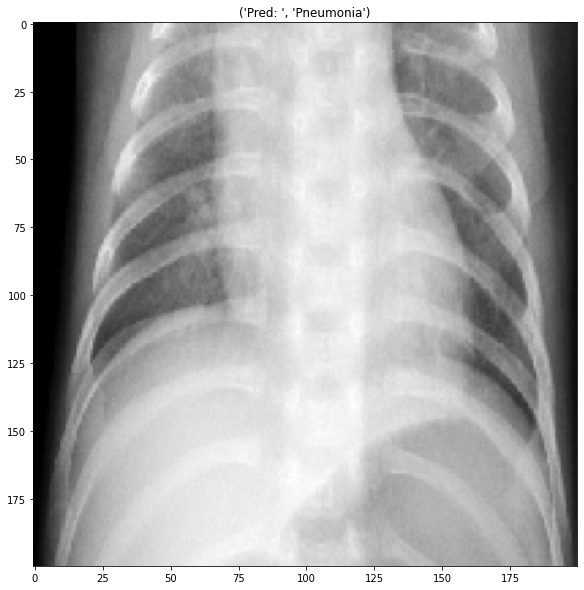

time: 722 ms (started: 2021-07-18 20:21:33 +00:00)


In [66]:
#Buscando uma imagem real
#Essa imagem eh uma imagem de covid mas nao esta no dataset do professor. Ela foi coletada da internet
img_real="/content/drive/MyDrive/Dataset/CoronaHack/teste_real/20200424101317.jpg"
image_norm= cv2.cvtColor(cv2.resize(cv2.imread(img_real),(200,200)), cv2.COLOR_BGR2GRAY)

#adicionando dimensões para entrada no modelo
img2= image_norm.reshape(1,200, 200,1)

#Realizando a classificação da imagem
y_pred_real = model.predict(img2)

#genrado a visualização na imagem
y_predicao = np.argmax(y_pred_real)

for i,v in enumerate(labels):
  if v[0] == y_predicao:
    y_predicao_label =v[1]
    
plt.figure(figsize=(10,10))    
title_text=("Pred: ", y_predicao_label)
plt.title(title_text)
image=x[0]
plt.imshow(image[:,:,0],cmap='gray')
plt.show()